In [5]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from scipy.stats import randint, uniform
import torch
import torch.nn as nn
import torch.optim as optim
from skorch.regressor import NeuralNetRegressor
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:

data = pd.read_csv(r'C:\Users\caixd\Downloads\ped-fusion-share\df1_v1a_out.csv')

NameError: name 'pd' is not defined

In [1]:
plt.figure(figsize=(8, 5))
plt.hist(data['pm_tot'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of ')
plt.xlabel('PM_TOT')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [6]:
datafinal = data.copy()

In [7]:
# transform skewed response var
datafinal['log_pm_tot'] = np.log1p(datafinal['pm_tot'])
datafinal['log_pm_tot_transform'] = datafinal['log_pm_tot'] - np.log(datafinal['Number of'])


In [8]:
def avg_speed_range(speed_str):
    speeds = [int(s.replace('mph', '').strip()) for s in speed_str.split('-')]
    return sum(speeds) / len(speeds)
  
datafinal['speed_numeric'] = data['speed_type'].apply(avg_speed_range)

In [9]:
data_num = datafinal.drop(columns=['crossing_class','season','class_type', 'speed_type', 'Street Nam', 'site_id', '_Date','geometry','crossing_island', 'holdout'])

#col_names = data_num.columns
#print(col_names)

ycorr = data_num.corr()['log_pm_tot_transform']

low_corr = ycorr[abs(ycorr) < 0.1].index

print(low_corr)






Index(['bus_stops', 'Retail Area', 'tstop_dens', 'Commercial Area_em',
       'Retail Area_em', 'Park Area_em', 'Commercial Area_qm',
       'Retail Area_qm', 'Retail Area_hm'],
      dtype='object')


In [10]:

datafinal = pd.get_dummies(
    datafinal,
    columns=['crossing_class', 'season'],
    prefix=['crossing', 'season']
)

terms = ['pri', 'res', 'sec', 'ter', 'mot', 'tru']
for term in terms:
    datafinal[term] = datafinal['class_type'].apply(lambda x: int(term in x))

In [11]:
'''datafinal = datafinal.drop(columns = ['bus_stops', 'Retail Area', 'tstop_dens', 'Commercial Area_em',
       'Retail Area_em', 'Park Area_em', 'Commercial Area_qm',
       'Retail Area_qm', 'Retail Area_hm'])'''

cols_drop = [col for col in datafinal.columns if col.endswith('_hm')]
datafinal = datafinal.drop(columns=cols_drop)

In [12]:
datafinal = datafinal.drop(columns = ['Street Nam', 'site_id','_Date','geometry','class_type','speed_type'])

In [13]:
X = datafinal.drop(columns = ['pm_tot','log_pm_tot','log_pm_tot_transform'])
y = datafinal[['log_pm_tot_transform']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

X_test_number_of = X_test['Number of'].values
X_train = X_train.drop(columns = ['Number of'])
X_test = X_test.drop(columns = ['Number of'])
                       

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)
#model
elastic_net_cv = ElasticNetCV(
    l1_ratio=[.1, .5, .7, .9, .95, 1], 
    alphas=np.logspace(-4, 2, 50),      
    cv=5,
    max_iter=10000,
    random_state=2
)

elastic_net_cv.fit(X_train_scale, y_train)

#predict
y_pred = elastic_net_cv.predict(X_test_scale)
y_pred_pm_tot = np.expm1(y_pred + np.log(X_test_number_of))
y_true_pm_tot = datafinal.loc[y_test.index, 'pm_tot']

#evaluate
mse = mean_squared_error(y_true_pm_tot, y_pred_pm_tot)
r2 = r2_score(y_true_pm_tot, y_pred_pm_tot)

print("Best alpha:", elastic_net_cv.alpha_)
print("Best l1_ratio:", elastic_net_cv.l1_ratio_)
mse = mean_squared_error(y_true_pm_tot, y_pred_pm_tot)
mae = mean_absolute_error(y_true_pm_tot, y_pred_pm_tot)
r2 = r2_score(y_true_pm_tot, y_pred_pm_tot)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.4f}")

c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.182e-02, tolerance: 8.240e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.683e-02, tolerance: 8.240e-03
  model =

Best alpha: 0.08685113737513521
Best l1_ratio: 0.1
MSE: 4156.51
MAE: 38.89
R2: 0.6569


c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.021e-01, tolerance: 6.589e-03
  model = cd_fast.enet_coordinate_descent(


In [14]:
X = datafinal.drop(columns = ['pm_tot','log_pm_tot','log_pm_tot_transform','stv_ann','stv_mi'])
y = datafinal[['log_pm_tot_transform']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

X_test_number_of = X_test['Number of'].values
X_train = X_train.drop(columns = ['Number of'])
X_test = X_test.drop(columns = ['Number of'])
                       

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)
#model
elastic_net_cv = ElasticNetCV(
    l1_ratio=[.1, .5, .7, .9, .95, 1], 
    alphas=np.logspace(-4, 2, 50),      
    cv=5,
    max_iter=10000,
    random_state=2
)

elastic_net_cv.fit(X_train_scale, y_train)

#predict
y_pred = elastic_net_cv.predict(X_test_scale)
y_pred_pm_tot = np.expm1(y_pred + np.log(X_test_number_of))
y_true_pm_tot = datafinal.loc[y_test.index, 'pm_tot']

#evaluate
mse = mean_squared_error(y_true_pm_tot, y_pred_pm_tot)
r2 = r2_score(y_true_pm_tot, y_pred_pm_tot)

print("Best alpha:", elastic_net_cv.alpha_)
print("Best l1_ratio:", elastic_net_cv.l1_ratio_)
mse = mean_squared_error(y_true_pm_tot, y_pred_pm_tot)
mae = mean_absolute_error(y_true_pm_tot, y_pred_pm_tot)
r2 = r2_score(y_true_pm_tot, y_pred_pm_tot)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.4f}")

c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.649e-02, tolerance: 8.240e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.965e-02, tolerance: 8.240e-03
  model =

Best alpha: 0.015998587196060572
Best l1_ratio: 1.0
MSE: 8112.94
MAE: 50.99
R2: 0.3304


c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.145e-01, tolerance: 6.589e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.358e-02, tolerance: 6.589e-03
  model = cd_fast.enet_coordinate_descent(


In [33]:
X = datafinal.drop(columns = ['pm_tot','log_pm_tot','log_pm_tot_transform'])
y = datafinal[['log_pm_tot_transform']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

X_test_number_of = X_test['Number of'].values
X_train = X_train.drop(columns = ['Number of'])
X_test = X_test.drop(columns = ['Number of'])

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=2)
param_dist = {
    'n_estimators': randint(50, 400),
    'max_depth': randint(3, 25),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4), 
    'colsample_bytree': uniform(0.6, 0.4)
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=100,            
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=2,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

#find best model then evaluate using original scale of pm tot
best_model = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)

y_pred_log = best_model.predict(X_test)

#undo the pm tot transformation
y_pred_pm_tot = np.expm1(y_pred_log + np.log(X_test_number_of))

y_true_pm_tot = datafinal.loc[y_test.index, 'pm_tot']


mse = mean_squared_error(y_true_pm_tot, y_pred_pm_tot)
mae = mean_absolute_error(y_true_pm_tot, y_pred_pm_tot)
r2 = r2_score(y_true_pm_tot, y_pred_pm_tot)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.4f}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'colsample_bytree': np.float64(0.825142959566288), 'learning_rate': np.float64(0.171838328372298), 'max_depth': 4, 'n_estimators': 91, 'subsample': np.float64(0.7203012280013417)}
MSE: 2327.27
MAE: 32.46
R2: 0.8079


In [32]:
train_data = datafinal[datafinal['holdout'] == 0].copy()
test_data = datafinal[datafinal['holdout'] == 1].copy()

# Define X and y
X_train = train_data.drop(columns=['pm_tot', 'log_pm_tot', 'log_pm_tot_transform'])
y_train = train_data[['log_pm_tot_transform']]

X_test = test_data.drop(columns=['pm_tot', 'log_pm_tot', 'log_pm_tot_transform'])
y_test = test_data[['log_pm_tot_transform']]

# Save 'Number of' before dropping from features
X_train_number_of = X_train['Number of'].values
X_test_number_of = X_test['Number of'].values

X_train = X_train.drop(columns=['Number of'])
X_test = X_test.drop(columns=['Number of'])

# Define model and hyperparameter search space
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=1)
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(3, 20),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0.5, 5),
}

# Randomized hyperparameter search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=2,
    n_jobs=-1
)

# Fit model
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_
print("Best parameters found:", random_search.best_params_)

# Predict on holdout set (test)
y_pred_log = best_model.predict(X_test)

# Inverse transformation to get pm_tot
y_pred_pm_tot = np.expm1(y_pred_log + np.log(X_test_number_of))
y_true_pm_tot = test_data['pm_tot'].values

# Evaluation
mse = mean_squared_error(y_true_pm_tot, y_pred_pm_tot)
mae = mean_absolute_error(y_true_pm_tot, y_pred_pm_tot)
r2 = r2_score(y_true_pm_tot, y_pred_pm_tot)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found: {'colsample_bytree': np.float64(0.8359127965887055), 'gamma': np.float64(0.26111363692080114), 'learning_rate': np.float64(0.029699099861913263), 'max_depth': 19, 'min_child_weight': 7, 'n_estimators': 472, 'reg_alpha': np.float64(0.018985127422414982), 'reg_lambda': np.float64(2.7501336111883488), 'subsample': np.float64(0.6121473010667159)}
MSE: 9681.48
MAE: 54.04
R2: 0.6828


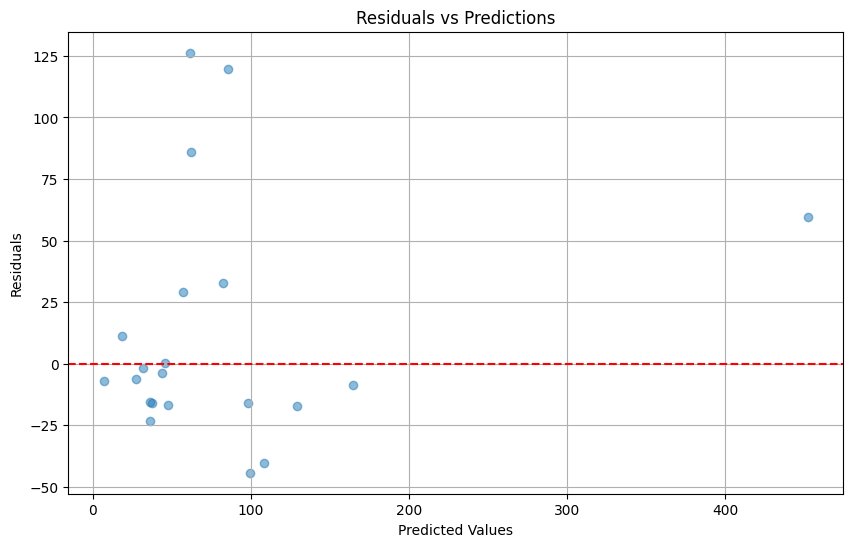

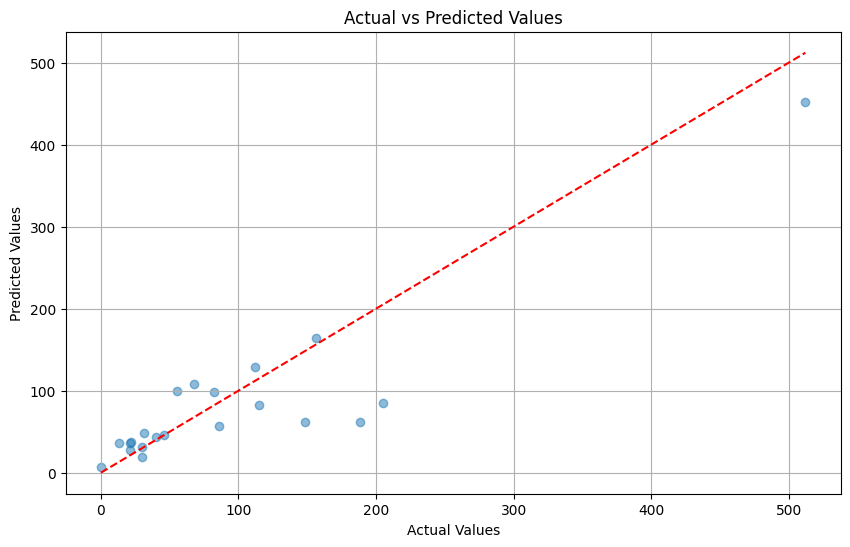

In [34]:
#these plot code is generated by chatgpt

residuals = y_true_pm_tot - y_pred_pm_tot.flatten()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_pm_tot, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_true_pm_tot, y_pred_pm_tot, alpha=0.5)
plt.plot([min(y_true_pm_tot), max(y_true_pm_tot)], 
         [min(y_true_pm_tot), max(y_true_pm_tot)], 
         color='r', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [17]:
X = datafinal.drop(columns = ['pm_tot','log_pm_tot','log_pm_tot_transform','stv_ann','stv_mi'])
y = datafinal[['log_pm_tot_transform']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

X_test_number_of = X_test['Number of'].values
X_train = X_train.drop(columns = ['Number of'])
X_test = X_test.drop(columns = ['Number of'])

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=2)
param_dist = {
    'n_estimators': randint(50, 400),
    'max_depth': randint(3, 25),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4), 
    'colsample_bytree': uniform(0.6, 0.4)
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,            
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=2,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

#find best model then evaluate using original scale of pm tot
best_model = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)

y_pred_log = best_model.predict(X_test)

#undo the pm tot transformation
y_pred_pm_tot = np.expm1(y_pred_log + np.log(X_test_number_of))

y_true_pm_tot = datafinal.loc[y_test.index, 'pm_tot']


mse = mean_squared_error(y_true_pm_tot, y_pred_pm_tot)
mae = mean_absolute_error(y_true_pm_tot, y_pred_pm_tot)
r2 = r2_score(y_true_pm_tot, y_pred_pm_tot)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'colsample_bytree': np.float64(0.7321339284015497), 'learning_rate': np.float64(0.07139459021135275), 'max_depth': 24, 'n_estimators': 97, 'subsample': np.float64(0.7198618694698092)}
MSE: 3118.31
MAE: 35.11
R2: 0.7426


In [18]:
X = datafinal.drop(columns=['pm_tot','log_pm_tot','log_pm_tot_transform'])
y = datafinal['log_pm_tot_transform'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, X.index, test_size=0.2, random_state=2
)

X_test_number_of = X_test['Number of'].values.reshape(-1, 1).astype(np.float32)
X_train = X_train.drop(columns = ['Number of'])
X_test = X_test.drop(columns = ['Number of'])

#scaling
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

y_train, y_test = y_train.astype(np.float32), y_test.astype(np.float32)
X_train_scale = X_train_scale.astype(np.float32)
X_test_scale = X_test_scale.astype(np.float32)

#model structure
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, units1=64, units2=32, dropout_rate=0.2):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, units1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(units1, units2),
            nn.ReLU(),
            nn.Linear(units2, 1)
        )

    def forward(self, X):
        return self.layers(X)

net = NeuralNetRegressor(
    module=FeedforwardNN,
    module__input_dim=X_train.shape[1],
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=32,
    verbose=0,
    device='cpu'  
)

#hyperparameter tuning
param_dist = {
    'module__units1': [32, 64, 128, 256],
    'module__units2': [16, 32, 64, 128],
    'module__dropout_rate': uniform(0.1, 0.5),
    'optimizer__lr': uniform(1e-4, 1e-2),
    'batch_size': [16, 32, 64],
}

random_search = RandomizedSearchCV(
    estimator=net,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=2,
    n_jobs=-1
)


random_search.fit(X_train_scale, y_train)
    
#evaluate
print("Best parameters found: ", random_search.best_params_)
best_model = random_search.best_estimator_
y_pred_log = best_model.predict(X_test_scale)
y_pred_pm_tot = np.expm1(y_pred_log + np.log(X_test_number_of))
y_true_pm_tot = datafinal.loc[idx_test, 'pm_tot'].values

mse = mean_squared_error(y_true_pm_tot, y_pred_pm_tot)
mae = mean_absolute_error(y_true_pm_tot, y_pred_pm_tot)
r2 = r2_score(y_true_pm_tot, y_pred_pm_tot)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'batch_size': 64, 'module__dropout_rate': np.float64(0.16357998585063874), 'module__units1': 128, 'module__units2': 16, 'optimizer__lr': np.float64(0.0023601200060423587)}
MSE: 9853.22
MAE: 61.88
R2: 0.1867


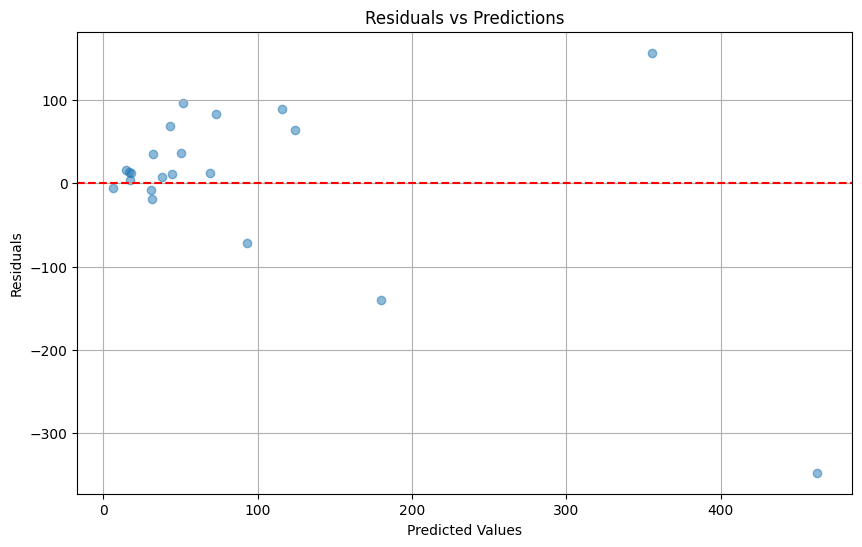

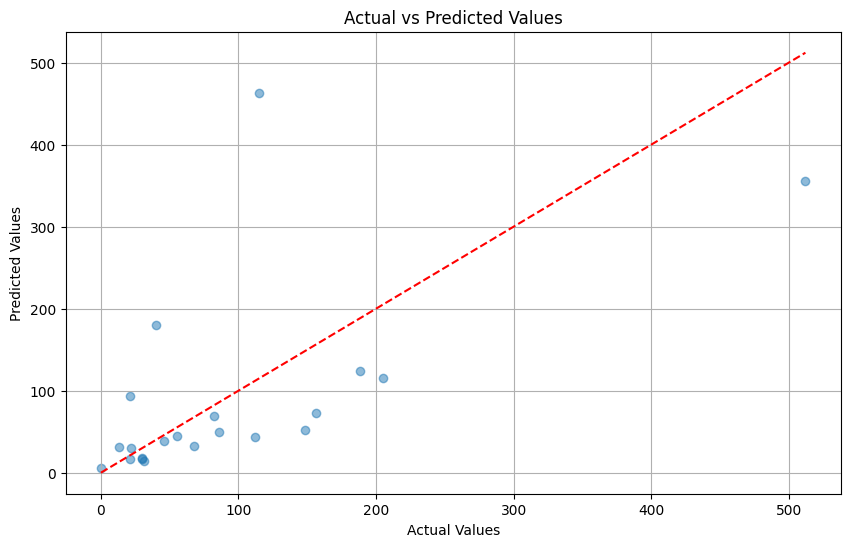

In [19]:


residuals = y_true_pm_tot - y_pred_pm_tot.flatten()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_pm_tot, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_true_pm_tot, y_pred_pm_tot, alpha=0.5)
plt.plot([min(y_true_pm_tot), max(y_true_pm_tot)], 
         [min(y_true_pm_tot), max(y_true_pm_tot)], 
         color='r', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [20]:
X = datafinal.drop(columns=['pm_tot','log_pm_tot','log_pm_tot_transform','stv_ann','stv_mi'])
y = datafinal['log_pm_tot_transform'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, X.index, test_size=0.2, random_state=2
)

X_test_number_of = X_test['Number of'].values.reshape(-1, 1).astype(np.float32)
X_train = X_train.drop(columns = ['Number of'])
X_test = X_test.drop(columns = ['Number of'])

#scaling
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

y_train, y_test = y_train.astype(np.float32), y_test.astype(np.float32)
X_train_scale = X_train_scale.astype(np.float32)
X_test_scale = X_test_scale.astype(np.float32)

#model structure
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, units1=64, units2=32, dropout_rate=0.2):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, units1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(units1, units2),
            nn.ReLU(),
            nn.Linear(units2, 1)
        )

    def forward(self, X):
        return self.layers(X)

net = NeuralNetRegressor(
    module=FeedforwardNN,
    module__input_dim=X_train.shape[1],
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=32,
    verbose=0,
    device='cpu'  
)

#hyperparameter tuning
param_dist = {
    'module__units1': [32, 64, 128, 256],
    'module__units2': [16, 32, 64, 128],
    'module__dropout_rate': uniform(0.1, 0.5),
    'optimizer__lr': uniform(1e-4, 1e-2),
    'batch_size': [16, 32, 64],
}

random_search = RandomizedSearchCV(
    estimator=net,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=2,
    n_jobs=-1
)


random_search.fit(X_train_scale, y_train)
#evaluate
print("Best parameters found: ", random_search.best_params_)
best_model = random_search.best_estimator_
y_pred_log = best_model.predict(X_test_scale)
y_pred_pm_tot = np.expm1(y_pred_log + np.log(X_test_number_of))
y_true_pm_tot = datafinal.loc[idx_test, 'pm_tot'].values

mse = mean_squared_error(y_true_pm_tot, y_pred_pm_tot)
mae = mean_absolute_error(y_true_pm_tot, y_pred_pm_tot)
r2 = r2_score(y_true_pm_tot, y_pred_pm_tot)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'batch_size': 32, 'module__dropout_rate': np.float64(0.5663142822055274), 'module__units1': 128, 'module__units2': 64, 'optimizer__lr': np.float64(0.005274307637214693)}
MSE: 6801.73
MAE: 53.12
R2: 0.4386


In [21]:
from sklearn.svm import SVR
X = datafinal.drop(columns=['pm_tot', 'log_pm_tot', 'log_pm_tot_transform'])
y = datafinal[['log_pm_tot_transform']]

#split data and get indices of the test set
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, X.index, test_size=0.2, random_state=2
)
#get number of col from the test set and then drop it from both train and test
X_test_number_of = X_test['Number of'].values

X_train = X_train.drop(columns=['Number of'])
X_test = X_test.drop(columns=['Number of'])

#scaling
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

model = SVR()

#hyperparameter set and tuning
param_dist = {
    'C': uniform(0.1, 100),
    'epsilon': uniform(0.01, 1),
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=2,
    n_jobs=-1
)

#fit and find best
random_search.fit(X_train_scale, y_train.values.ravel())

best_model = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)

#evaluate performance using original scale of counts
y_pred_log = best_model.predict(X_test_scale)
y_pred_pm_tot = np.expm1(y_pred_log + np.log(X_test_number_of))

y_true_pm_tot = datafinal.loc[idx_test, 'pm_tot'].values

mse = mean_squared_error(y_true_pm_tot, y_pred_pm_tot)
mae = mean_absolute_error(y_true_pm_tot, y_pred_pm_tot)
r2 = r2_score(y_true_pm_tot, y_pred_pm_tot)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.4f}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found:  {'C': np.float64(42.854596329611006), 'epsilon': np.float64(0.446747263026799), 'gamma': 'scale', 'kernel': 'linear'}
MSE: 6687.33
MAE: 47.28
R2: 0.4480


In [22]:

X = datafinal.drop(columns=['pm_tot', 'log_pm_tot', 'log_pm_tot_transform','stv_ann','stv_mi'])
y = datafinal[['log_pm_tot_transform']]

#split data and get indices of the test set
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, X.index, test_size=0.2, random_state=2
)
#get number of col from the test set and then drop it from both train and test
X_test_number_of = X_test['Number of'].values

X_train = X_train.drop(columns=['Number of'])
X_test = X_test.drop(columns=['Number of'])

#scaling
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

model = SVR()

#hyperparameter set and tuning
param_dist = {
    'C': uniform(0.1, 100),
    'epsilon': uniform(0.01, 1),
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=2,
    n_jobs=-1
)

#fit and find best
random_search.fit(X_train_scale, y_train.values.ravel())

best_model = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)

#evaluate performance using original scale of counts
y_pred_log = best_model.predict(X_test_scale)
y_pred_pm_tot = np.expm1(y_pred_log + np.log(X_test_number_of))

y_true_pm_tot = datafinal.loc[idx_test, 'pm_tot'].values

mse = mean_squared_error(y_true_pm_tot, y_pred_pm_tot)
mae = mean_absolute_error(y_true_pm_tot, y_pred_pm_tot)
r2 = r2_score(y_true_pm_tot, y_pred_pm_tot)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.4f}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found:  {'C': np.float64(13.557994534493355), 'epsilon': np.float64(0.5235781212657464), 'gamma': 'auto', 'kernel': 'linear'}
MSE: 22852.46
MAE: 70.29
R2: -0.8862
